In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForTokenClassification, pipeline
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Define the maximum sequence length
MAX_SEQ_LENGTH = 128

# Load NER model for preprocessing
ner_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
ner_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, device=device)

# NER preprocessing function
def extract_entities_and_anonymize(text):
    ner_results = ner_pipeline(text)
    extracted_entities = []

    # Replace entities with their labels
    for result in ner_results:
        start, end = result['start'], result['end']
        entity = result['word']
        label = result['entity']
        extracted_entities.append(entity)
        text = text[:start] + f"[{label}] " + text[end:]
    
    return text, extracted_entities

# Function to process a single text file and return sequences with labels for a specific tokenizer
def process_file(file_path, label, tokenizer):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Apply NER anonymization
    text, _ = extract_entities_and_anonymize(text)

    # Tokenize the entire text
    tokens = tokenizer(text, add_special_tokens=False)
    input_ids = tokens['input_ids']

    # Split the input IDs into chunks of MAX_SEQ_LENGTH
    chunks = [input_ids[i:i + MAX_SEQ_LENGTH] for i in range(0, len(input_ids), MAX_SEQ_LENGTH)]

    # Attach label and file name to each sequence
    labeled_sequences = [(chunk, label, file_path) for chunk in chunks]
    
    return labeled_sequences

# Function to process multiple files for a specific category
def process_category(file_paths, label, tokenizer):
    all_sequences = []
    file_sequence_counts = {}
    
    for file_path in file_paths:
        labeled_sequences = process_file(file_path, label, tokenizer)
        file_sequence_counts[file_path] = len(labeled_sequences)
        all_sequences.extend(labeled_sequences)
    
    return all_sequences, file_sequence_counts

# Function to convert sequences into a DataFrame
def sequences_to_dataframe(sequences, tokenizer):
    texts = [tokenizer.decode(seq[0]) for seq in sequences]
    labels = [seq[1] for seq in sequences]
    return pd.DataFrame({'content': texts, 'category': labels})

# Specify file paths for Train, Test, and Valid sets
test_files_0 = ["./data/train/0_The_Hound_of_the_Baskervilles_CD.txt"]
test_files_1 = ["./data/test/1_POIROT_INVESTIGATES.txt"]

valid_files_0 = ["./data/train/0_The_Man_Who_Was_Thursday_GKC.txt"]
valid_files_1 = ["./data/train/1_THE_BIG_FOUR.txt"]

train_files_0 = [
    "./data/train/0_The_Mystery_of_the_Yellow_Room_GL.txt",
    "./data/train/0_The_Middle_Temple_Murder_JF.txt",
    "./data/train/0_JOHN_THORNDYKE'S_CASES_RF.txt",
    "./data/train/0_A_Study_in_Scarlet_CD.txt",
    "./data/train/0_Tremendous_Trifles_GKC.txt",
    "./data/test/0_Caught_in_the_Net_EG.txt",
    "./data/valid/0_The_Red_House_Mystery_AM.txt"
]

train_files_1 = [
    "./data/train/1_The_Secret_of_Chimneys.txt",
    "./data/train/1_The_Mystery_of_the_Blue_Train.txt",
    "./data/train/1_The_Mysterious_Affair_at_Styles.txt",
    "./data/train/1_The_Murder_on_the_Links.txt",
    "./data/train/1_The_Murder_of_Roger_Ackroyd.txt",
    "./data/train/1_THE_MAN_IN_THE_BROWN_SUIT.txt",
    "./data/valid/1_THE_SECRET_ADVERSARY.txt"
]

# Tokenizers for each model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
xlm_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Prepare data for each model
def prepare_data(tokenizer):
    test_sequences = process_category(test_files_0, label=0, tokenizer=tokenizer)[0] + \
                     process_category(test_files_1, label=1, tokenizer=tokenizer)[0]
    valid_sequences = process_category(valid_files_0, label=0, tokenizer=tokenizer)[0] + \
                      process_category(valid_files_1, label=1, tokenizer=tokenizer)[0]
    train_sequences = process_category(train_files_0, label=0, tokenizer=tokenizer)[0] + \
                      process_category(train_files_1, label=1, tokenizer=tokenizer)[0]

    train_data = sequences_to_dataframe(train_sequences, tokenizer)
    valid_data = sequences_to_dataframe(valid_sequences, tokenizer)
    test_data = sequences_to_dataframe(test_sequences, tokenizer)

    return train_data, valid_data, test_data

# Generate datasets for each model
train_data_bert, valid_data_bert, test_data_bert = prepare_data(bert_tokenizer)
train_data_distilbert, valid_data_distilbert, test_data_distilbert = prepare_data(distilbert_tokenizer)
train_data_xlm, valid_data_xlm, test_data_xlm = prepare_data(xlm_tokenizer)

# Tokenization
def tokenize_texts(texts, tokenizer, max_length=MAX_SEQ_LENGTH):
    return tokenizer(
        list(texts),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

# Tokenize for BERT
bert_train_encodings = tokenize_texts(train_data_bert['content'], bert_tokenizer)
bert_val_encodings = tokenize_texts(valid_data_bert['content'], bert_tokenizer)
bert_test_encodings = tokenize_texts(test_data_bert['content'], bert_tokenizer)

# Tokenize for DistilBERT
distilbert_train_encodings = tokenize_texts(train_data_distilbert['content'], distilbert_tokenizer)
distilbert_val_encodings = tokenize_texts(valid_data_distilbert['content'], distilbert_tokenizer)
distilbert_test_encodings = tokenize_texts(test_data_distilbert['content'], distilbert_tokenizer)

# Tokenize for XLM-RoBERTa
xlm_train_encodings = tokenize_texts(train_data_xlm['content'], xlm_tokenizer)
xlm_val_encodings = tokenize_texts(valid_data_xlm['content'], xlm_tokenizer)
xlm_test_encodings = tokenize_texts(test_data_xlm['content'], xlm_tokenizer)

# Prepare Dataset for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

# Create PyTorch datasets for BERT
bert_train_dataset = CustomDataset(bert_train_encodings, train_data_bert['category'])
bert_val_dataset = CustomDataset(bert_val_encodings, valid_data_bert['category'])
bert_test_dataset = CustomDataset(bert_test_encodings, test_data_bert['category'])

# Create PyTorch datasets for DistilBERT
distilbert_train_dataset = CustomDataset(distilbert_train_encodings, train_data_distilbert['category'])
distilbert_val_dataset = CustomDataset(distilbert_val_encodings, valid_data_distilbert['category'])
distilbert_test_dataset = CustomDataset(distilbert_test_encodings, test_data_distilbert['category'])

# Create PyTorch datasets for XLM-RoBERTa
xlm_train_dataset = CustomDataset(xlm_train_encodings, train_data_xlm['category'])
xlm_val_dataset = CustomDataset(xlm_val_encodings, valid_data_xlm['category'])
xlm_test_dataset = CustomDataset(xlm_test_encodings, test_data_xlm['category'])

# Prepare Dataset for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

# Create PyTorch datasets for BERT
bert_train_dataset = CustomDataset(bert_train_encodings, train_data_bert['category'])
bert_val_dataset = CustomDataset(bert_val_encodings, valid_data_bert['category'])
bert_test_dataset = CustomDataset(bert_test_encodings, test_data_bert['category'])

# Create PyTorch datasets for DistilBERT
distilbert_train_dataset = CustomDataset(distilbert_train_encodings, train_data_distilbert['category'])
distilbert_val_dataset = CustomDataset(distilbert_val_encodings, valid_data_distilbert['category'])
distilbert_test_dataset = CustomDataset(distilbert_test_encodings, test_data_distilbert['category'])

# Create PyTorch datasets for XLM-RoBERTa
xlm_train_dataset = CustomDataset(xlm_train_encodings, train_data_xlm['category'])
xlm_val_dataset = CustomDataset(xlm_val_encodings, valid_data_xlm['category'])
xlm_test_dataset = CustomDataset(xlm_test_encodings, test_data_xlm['category'])

# Plot metrics (loss and accuracy)
def plot_metrics(train_losses, eval_losses, eval_accuracies, model_name, fold):
    epochs = range(1, len(eval_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Per Epoch (Fold {fold + 1})')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Validation Accuracy Per Epoch (Fold {fold + 1})')
    plt.legend()

    plt.tight_layout()
    plt.show()

def cross_validate(model_class, model_name_or_path, tokenizer, train_data, num_folds=3, model_name="Model"):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    texts, labels = train_data['content'], train_data['category']
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\nFold {fold + 1}/{num_folds}")

        # Prepare fold datasets
        train_texts, val_texts = texts.iloc[train_idx], texts.iloc[val_idx]
        train_labels, val_labels = labels.iloc[train_idx], labels.iloc[val_idx]
        train_encodings = tokenize_texts(train_texts, tokenizer)
        val_encodings = tokenize_texts(val_texts, tokenizer)
        train_dataset = CustomDataset(train_encodings, train_labels)
        val_dataset = CustomDataset(val_encodings, val_labels)

        # Initialize model
        model = model_class.from_pretrained(model_name_or_path, num_labels=2)

        # TrainingArguments
        training_args = TrainingArguments(
            output_dir=f'./results_{model_name}_fold{fold}',
            evaluation_strategy='epoch',
            save_strategy='epoch',
            logging_strategy='epoch',
            learning_rate=2e-5,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            num_train_epochs=4,
            weight_decay=0.01,
            logging_dir=f'./logs_{model_name}_fold{fold}',
            load_best_model_at_end=True,
            report_to="none"
        )

        # Metrics
        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
            acc = accuracy_score(labels, predictions)
            return {'eval_accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        # Train the model
        trainer.train()

        # Extract metrics
        train_log = trainer.state.log_history
        epoch_logs = [log for log in train_log if 'epoch' in log.keys()]
        train_losses = [log['loss'] for log in epoch_logs if 'loss' in log]
        eval_losses = [log['eval_loss'] for log in epoch_logs if 'eval_loss' in log]
        eval_accuracies = [log['eval_accuracy'] for log in epoch_logs if 'eval_accuracy' in log]

        # Plot metrics for this fold
        plot_metrics(train_losses, eval_losses, eval_accuracies, model_name, fold)

        # Evaluate the model on validation set
        eval_results = trainer.evaluate(val_dataset)
        fold_metrics.append(eval_results)
        print(f"Metrics for Fold {fold + 1}: {eval_results}")

    avg_metrics = {key: np.mean([fold[key] for fold in fold_metrics]) for key in fold_metrics[0]}
    print(f"\nAverage Metrics Across {num_folds} Folds: {avg_metrics}")
    return avg_metrics

/home/km/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Token indices sequence length is longer than the specified maximum sequence length 


Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.189800,0.070632,0.979971,0.987514,0.973154,0.980282
2,0.031100,0.084049,0.981688,0.981027,0.983221,0.982123
3,0.005100,0.094420,0.982833,0.992588,0.973714,0.983060
4,0.000900,0.096212,0.984549,0.985442,0.984340,0.984891


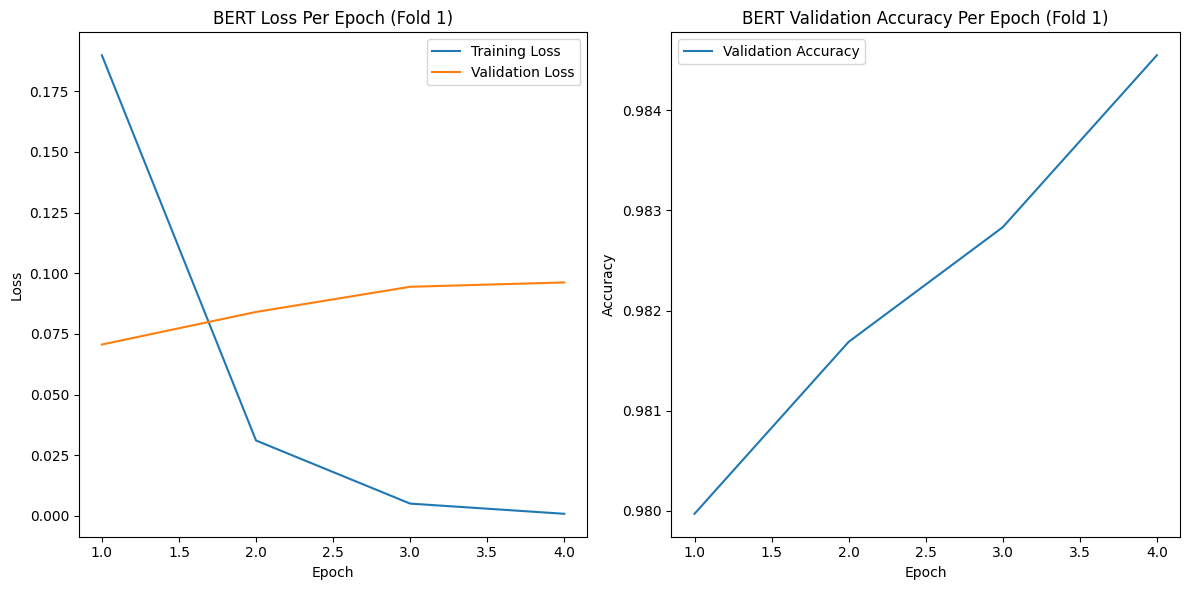

Metrics for Fold 1: {'eval_accuracy': 0.9799713876967096, 'eval_loss': 0.07063178718090057, 'eval_precision': 0.9875141884222475, 'eval_recall': 0.9731543624161074, 'eval_f1': 0.9802816901408451, 'eval_runtime': 2.4448, 'eval_samples_per_second': 1429.579, 'eval_steps_per_second': 44.994, 'epoch': 4.0}

Fold 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.196200,0.048447,0.983119,0.985947,0.980984,0.983459
2,0.031200,0.066710,0.984549,0.979535,0.990492,0.984983
3,0.010000,0.073920,0.985694,0.983315,0.988814,0.986057
4,0.000300,0.078028,0.985408,0.983306,0.988255,0.985774


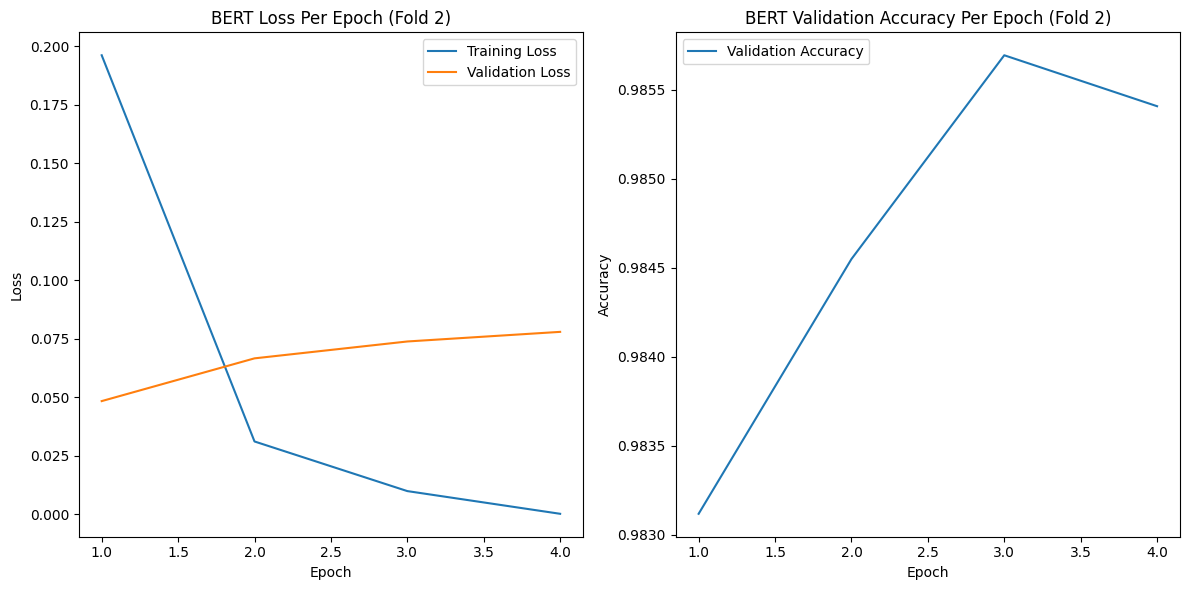

Metrics for Fold 2: {'eval_accuracy': 0.9831187410586553, 'eval_loss': 0.04844745248556137, 'eval_precision': 0.985947161326588, 'eval_recall': 0.9809843400447428, 'eval_f1': 0.9834594897673115, 'eval_runtime': 2.4627, 'eval_samples_per_second': 1419.195, 'eval_steps_per_second': 44.667, 'epoch': 4.0}

Fold 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.187000,0.078925,0.979679,0.987500,0.972580,0.979983
2,0.040100,0.065683,0.983686,0.993158,0.974818,0.983903
3,0.008300,0.077004,0.983114,0.993151,0.973699,0.983329
4,0.001600,0.065480,0.988266,0.983389,0.993844,0.988589


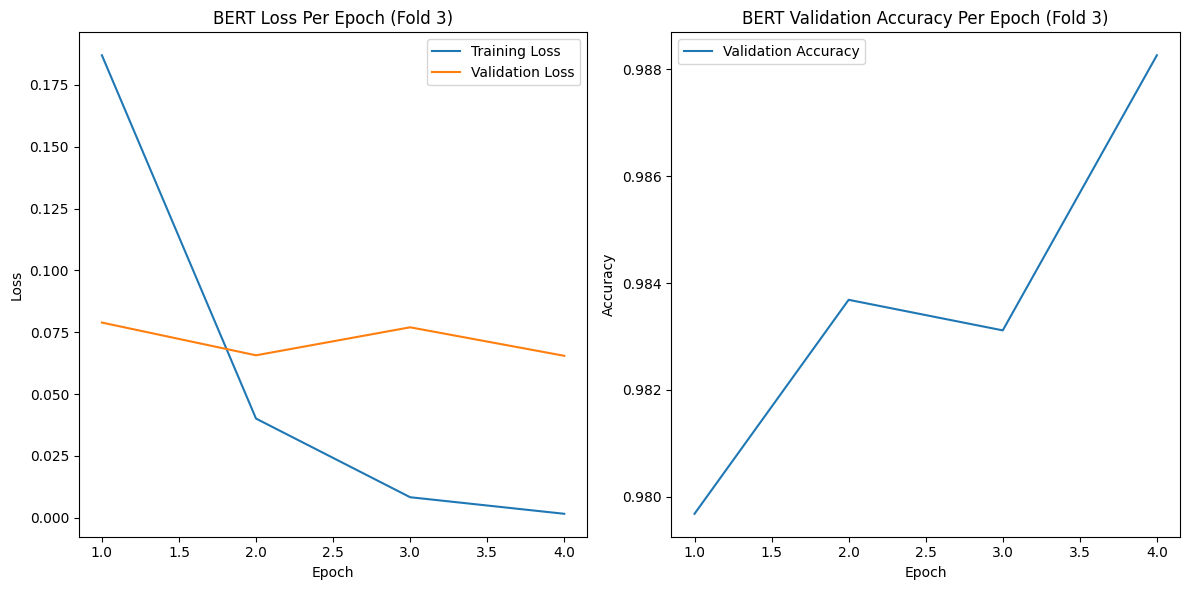

Metrics for Fold 3: {'eval_accuracy': 0.9882655981682885, 'eval_loss': 0.06548000872135162, 'eval_precision': 0.9833887043189369, 'eval_recall': 0.9938444320089536, 'eval_f1': 0.9885889229056499, 'eval_runtime': 2.448, 'eval_samples_per_second': 1427.278, 'eval_steps_per_second': 44.934, 'epoch': 4.0}

Average Metrics Across 3 Folds: {'eval_accuracy': np.float64(0.9837852423078844), 'eval_loss': np.float64(0.06151974946260452), 'eval_precision': np.float64(0.9856166846892576), 'eval_recall': np.float64(0.982661044823268), 'eval_f1': np.float64(0.9841100342712688), 'eval_runtime': np.float64(2.451833333333333), 'eval_samples_per_second': np.float64(1425.3506666666665), 'eval_steps_per_second': np.float64(44.865), 'epoch': np.float64(4.0)}


In [2]:
# Cross-validate for BERT
avg_metrics_bert = cross_validate(
    model_class=BertForSequenceClassification,
    model_name_or_path='bert-base-uncased',
    tokenizer=bert_tokenizer,
    train_data=train_data_bert,
    num_folds=3,
    model_name="BERT"
)


Fold 1/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.238200,0.099586,0.969153,0.984729,0.954496,0.969376
2,0.059800,0.085191,0.982053,0.981400,0.983553,0.982475
3,0.019600,0.088045,0.982053,0.979303,0.985746,0.982514
4,0.003000,0.093155,0.983735,0.976268,0.992325,0.984231


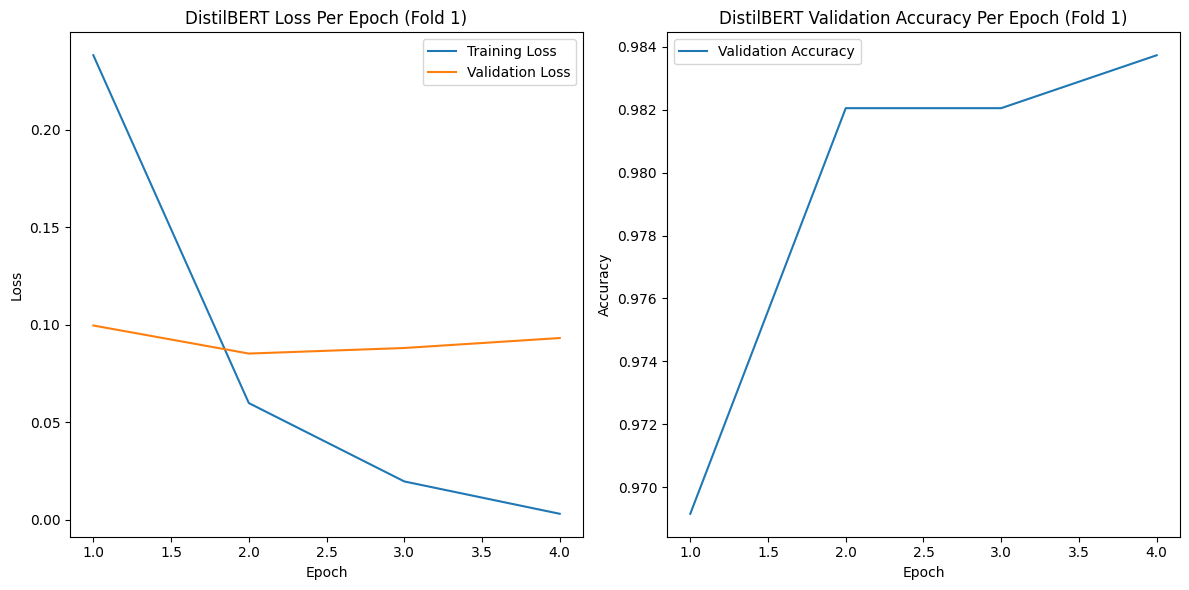

Metrics for Fold 1: {'eval_accuracy': 0.9820527201346047, 'eval_loss': 0.08519115298986435, 'eval_precision': 0.9814004376367614, 'eval_recall': 0.9835526315789473, 'eval_f1': 0.9824753559693319, 'eval_runtime': 1.2848, 'eval_samples_per_second': 2775.63, 'eval_steps_per_second': 87.176, 'epoch': 4.0}

Fold 2/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.232700,0.120553,0.951767,0.924499,0.986301,0.954401
2,0.073600,0.088918,0.977285,0.983907,0.971507,0.977667
3,0.025100,0.104268,0.978127,0.993782,0.963288,0.978297
4,0.006900,0.083782,0.982894,0.988914,0.977534,0.983191


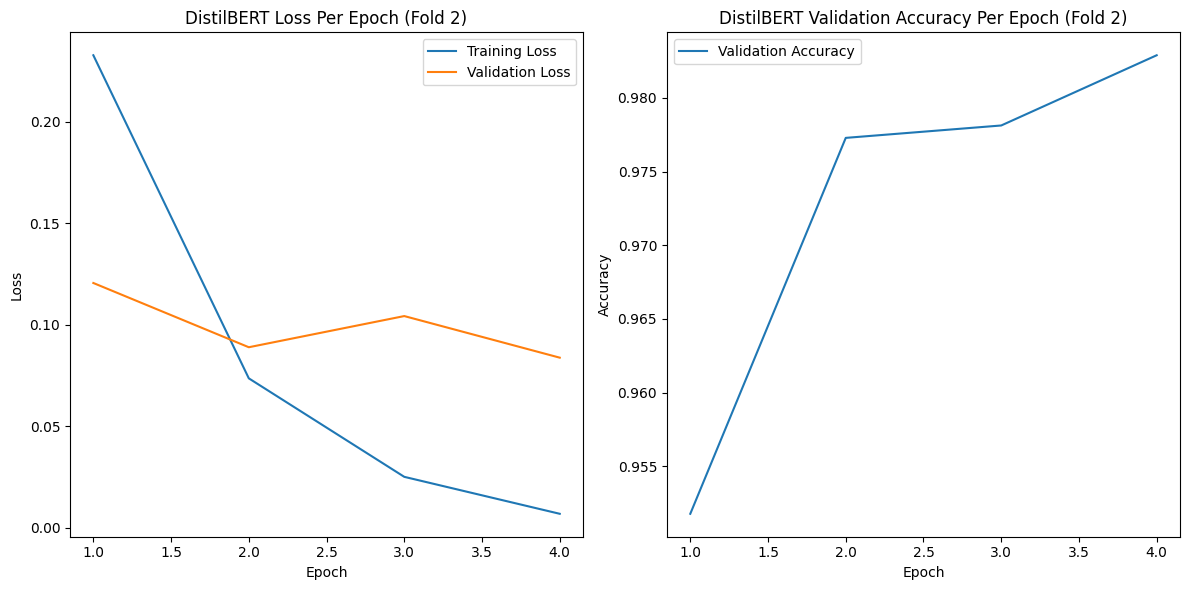

Metrics for Fold 2: {'eval_accuracy': 0.982893998878295, 'eval_loss': 0.08378167450428009, 'eval_precision': 0.9889135254988913, 'eval_recall': 0.9775342465753425, 'eval_f1': 0.9831909616974374, 'eval_runtime': 1.2934, 'eval_samples_per_second': 2757.039, 'eval_steps_per_second': 86.592, 'epoch': 4.0}

Fold 3/3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.243500,0.096280,0.968583,0.972928,0.965461,0.969180
2,0.063600,0.094679,0.973072,0.964017,0.984101,0.973956
3,0.025800,0.110657,0.977279,0.988235,0.967105,0.977556
4,0.005600,0.114393,0.975877,0.969730,0.983553,0.976592


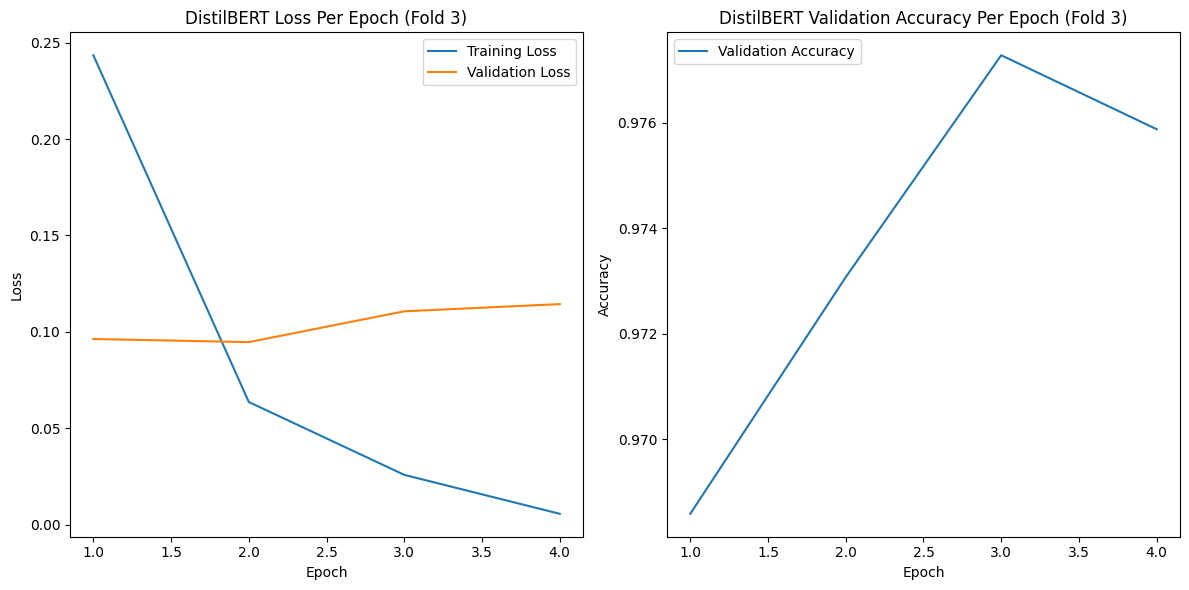

Metrics for Fold 3: {'eval_accuracy': 0.9730715287517532, 'eval_loss': 0.0946786180138588, 'eval_precision': 0.9640171858216972, 'eval_recall': 0.9841008771929824, 'eval_f1': 0.9739555073250136, 'eval_runtime': 1.2818, 'eval_samples_per_second': 2781.146, 'eval_steps_per_second': 87.374, 'epoch': 4.0}

Average Metrics Across 3 Folds: {'eval_accuracy': np.float64(0.9793394159215509), 'eval_loss': np.float64(0.08788381516933441), 'eval_precision': np.float64(0.9781103829857832), 'eval_recall': np.float64(0.9817292517824242), 'eval_f1': np.float64(0.9798739416639276), 'eval_runtime': np.float64(1.2866666666666666), 'eval_samples_per_second': np.float64(2771.271666666667), 'eval_steps_per_second': np.float64(87.04733333333333), 'epoch': np.float64(4.0)}


In [3]:
# Cross-validate for DistilBERT
avg_metrics_distilbert = cross_validate(
    model_class=DistilBertForSequenceClassification,
    model_name_or_path='distilbert-base-cased',
    tokenizer=distilbert_tokenizer,
    train_data=train_data_distilbert,
    num_folds=3,
    model_name="DistilBERT"
)


Fold 1/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.281800,0.138267,0.965792,0.979066,0.952978,0.965846
2,0.108600,0.074485,0.976399,0.983572,0.969697,0.976585
3,0.049800,0.131968,0.978255,0.988794,0.968130,0.978353
4,0.022100,0.129201,0.977990,0.979570,0.977011,0.978289


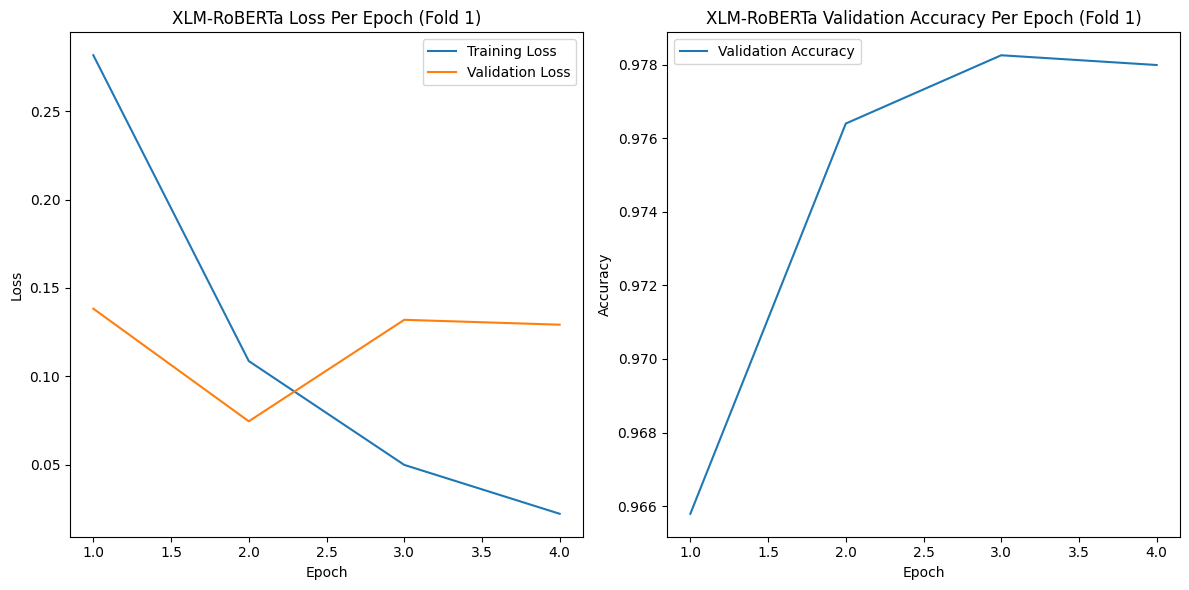

Metrics for Fold 1: {'eval_accuracy': 0.9763988332007425, 'eval_loss': 0.07448527216911316, 'eval_precision': 0.9835718071012188, 'eval_recall': 0.9696969696969697, 'eval_f1': 0.9765851091817943, 'eval_runtime': 2.6349, 'eval_samples_per_second': 1431.166, 'eval_steps_per_second': 44.783, 'epoch': 4.0}

Fold 2/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.296400,0.125245,0.962344,0.944779,0.983281,0.963646
2,0.089700,0.107949,0.975073,0.969072,0.982236,0.975610
3,0.045800,0.120707,0.974808,0.987668,0.962382,0.974861
4,0.021900,0.124687,0.978255,0.976091,0.981191,0.978635


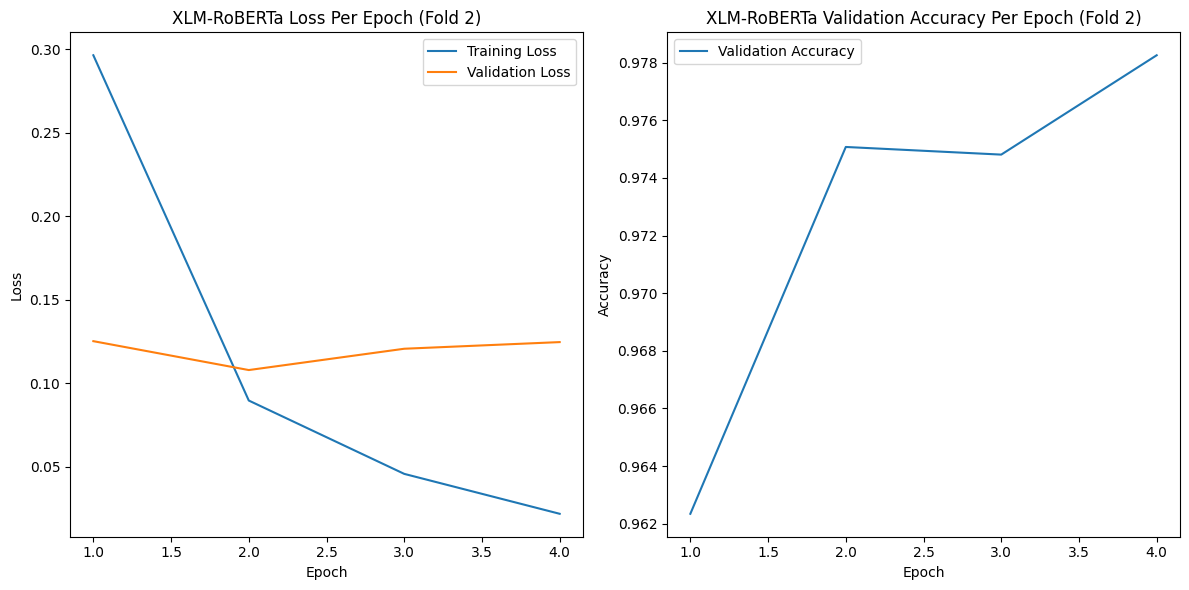

Metrics for Fold 2: {'eval_accuracy': 0.9750729249535932, 'eval_loss': 0.1079494059085846, 'eval_precision': 0.9690721649484536, 'eval_recall': 0.9822361546499477, 'eval_f1': 0.975609756097561, 'eval_runtime': 2.6745, 'eval_samples_per_second': 1410.001, 'eval_steps_per_second': 44.121, 'epoch': 4.0}

Fold 3/3


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/km/pytorch_env/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299100,0.121713,0.961018,0.937624,0.989034,0.962643
2,0.099800,0.115824,0.974543,0.971488,0.978590,0.975026
3,0.029000,0.103102,0.983294,0.975359,0.992167,0.983691
4,0.012200,0.091591,0.984619,0.985363,0.984334,0.984848


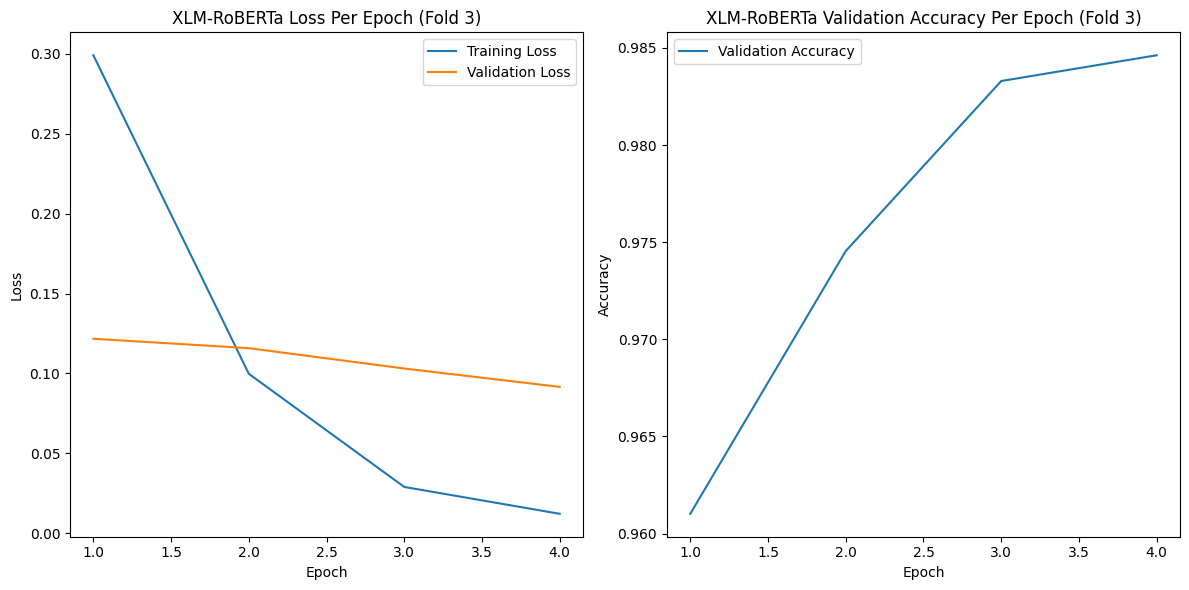

Metrics for Fold 3: {'eval_accuracy': 0.9846194643330681, 'eval_loss': 0.09159144014120102, 'eval_precision': 0.985363303711448, 'eval_recall': 0.9843342036553525, 'eval_f1': 0.9848484848484849, 'eval_runtime': 2.6486, 'eval_samples_per_second': 1423.775, 'eval_steps_per_second': 44.552, 'epoch': 4.0}

Average Metrics Across 3 Folds: {'eval_accuracy': np.float64(0.978697074162468), 'eval_loss': np.float64(0.09134203940629959), 'eval_precision': np.float64(0.9793357585870401), 'eval_recall': np.float64(0.9787557760007567), 'eval_f1': np.float64(0.9790144500426133), 'eval_runtime': np.float64(2.6526666666666667), 'eval_samples_per_second': np.float64(1421.6473333333333), 'eval_steps_per_second': np.float64(44.48533333333333), 'epoch': np.float64(4.0)}


In [4]:
# Cross-validate for XLM-RoBERTa
avg_metrics_xlm = cross_validate(
    model_class=AutoModelForSequenceClassification,
    model_name_or_path='xlm-roberta-base',
    tokenizer=xlm_tokenizer,
    train_data=train_data_xlm,
    num_folds=3,
    model_name="XLM-RoBERTa"
)